# Pose Prediction From Smartwatch Data
### Part 2

Welcome, this notebook is the second chapter of the hackathon challenge to predict human arm pose from the sensor data of a single smartwatch. In other words, a human wears a smartwatch, and we will try to predict their arm pose from the sensor outputs we can read from the watch.

## Creating a Predictive Model with Machine Learning

In this second chapter, we will have the opportunity to utilize the processed data from the previous chapter and train a basic Neural Network to generate predictions. The following sections will guide you step-by-step for model architecture design, model training and evaluation, performance analysis and 3D visualization for better interpretability of the model's performance. 

Model Architecture Design:
The notebook includes the design and definition of the neural network architecture. Utilizing the popular PyTorch library, the model's architecture is structured, comprising input, two hidden, and output layers. The choice of activation functions, loss functions, and optimization algorithms is also made in this section.

Model Training:
The neural network is trained using the preprocessed dataset. The notebook implements the training loop, where batches of data are fed into the model iteratively. During training, the model learns to optimize its parameters to minimize the defined loss function through backpropagation. Training hyperparameters, such as learning rate, batch size, and number of epochs, may be fine-tuned to achieve optimal performance.

Model Evaluation:
Following training, the notebook evaluates the neural network's performance on a separate test dataset to assess its generalization ability. The option to define an loss criterion is also implemented in this section to gauge the model's effectiveness in correctly predicting unseen data.

Performance Analysis:
The notebook visualizes the model's training and validation curves to analyze its learning progress and detect signs of overfitting or underfitting. Analyzing these curves aids in fine-tuning the model's architecture or regularization techniques to achieve a better balance between accuracy and generalization.

3D Visualization:
Since we will be using the neural networks to estimate the X, Y & Z coordinates, a 3D visualization is presented for the outputs and actual labels to gain a deeper understanding of model's performance. The notebook leverages libraries like Plotly for interactive 3D visualizations.

Conclusion and Next Steps:
The notebook concludes with a summary of the neural network's performance and insights gained during the training process. Possible avenues for improvement, such as hyperparameter tuning, advanced architectures, or using pre-trained models, are suggested for future exploration.

### 0. Downloading Dependencies (Optional)

We begin by downloading the libraries in this notebook. In case you have all of these pre-installed, you may skip this step.

Note: Some packages were already installed in the first notebook. In case you skipped running the previous notebook, please run step 0 from the first notebook and then you may continute with this notebook. 

In [1]:
!pip install torch
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


### 1. Importing Libraries

Lets import the libraries we will be primarily working with in this notebook. You may notice some similar ones. Let us help you understand why:
- Libraries like Numpy and Pandas are extremely helpful for mathematical functions and data frameworks respectively. Therefore, you would see them almost everywhere.
- Matplotlib is often used to display plots and using plotly, we will display interactive plots. But why do we need plots for training a machine learning model? You will find out soon. 
- Finally, Torch refers to PyTorch that provides powerful tools to deploy Neural Networks (NN)

In [2]:
# PyTorch Libraries for Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split    # Scikit-Lean for preparing the train-test data split

import pandas as pd
import numpy as np

# Plotting tools
import matplotlib.pyplot as plt
import plotly.graph_objs as go

# adjust data paths in config.py
import config   
import os    

### 2. Loading Processed Data

Time for us to load the normalized dataset into the environment that we processed in the previous notebook. You will notice two files in the chache folder. 
1. `normalized_data.csv` contains the normalized dataset
2. `means_stds.csv` contains the means and standard deviations of different columns that were utilized during normalization process.

In [3]:
cache_path = config.paths["cache_path"]
path = os.path.join(cache_path, "normalized_data.csv")
data_normalized = pd.read_csv(path)

### 3. Plotting Functions
Lets get the simpler stuff out of the way first. Since the neural networks will help to estimate the X, Y & Z coordinates, we use a similar 3D visualization for representing the outputs by the model and actual labels to gain a deeper understanding of model's performance. 

Secondly, during the training process you will notice the loss decreases with epochs. It is useful to visualize the loss for a number of reasons:
- Overfitting: When model starts remembering the training dataset instead of figuring out a "pattern".
- Performance: To figure out if further training decreases or increases loss 

Note: Epoch refers to the iteration number where the model goes through the entire training data. For instance, 1 epoch indicates that model has passed through the data once. 

For these purposes, we are using helper functions that can be called repeatedly. 

In [4]:
"""
    This section represents the function and helper function required for interactive 3D visualization:
        - The interactive_output_visualization function helps in visualizing the X, Y, Z coordinates in an interactive 3D map. It is also used to display the output and original labels
"""

# Helper function that provides appropriate the approriate length for columns. 
# The duration variable helps in defining the length of continuous data - this helps in visualizing a smaller hand trajectory 
# The randomseed variable helps to visualize the same data without randomizing the selection process
# The remaining functions follow the same variables and analogy
def data_visualization(data, duration, randomseed=False, output=False):
    if output is True:
        dim1, dim2, dim3 = data[:,0], data[:,1], data[:,2]
    else:
        dim1, dim2, dim3 = np.array(data['gt_hand_orig_rua_x']), np.array(data['gt_hand_orig_rua_y']), np.array(data['gt_hand_orig_rua_z'])

    if duration is not None:
        if randomseed:
            np.random.seed(42)
        else: 
            np.random.seed(None)
        reduced_samples = 10 * duration
        start_index = np.random.choice(len(dim1) - reduced_samples + 1)
        dim1 = dim1[start_index : start_index + reduced_samples]
        dim2 = dim2[start_index : start_index + reduced_samples]
        dim3 = dim3[start_index : start_index + reduced_samples]
        
    return dim1, dim2, dim3

def interactive_output_visualization(data, duration=None, randomseed=False, output=False, output_data = None):
    dim1, dim2, dim3 = data_visualization(data, duration, randomseed, output)
    
    trace = go.Scatter3d(x=dim1, y=dim2, z=dim3, mode='markers', marker=dict(size=3, 
                                                                             color='blue', 
                                                                             opacity=0.8),
                                                                             name="Input Points")

    if output:
        dim1, dim2, dim3 = data_visualization(output_data, duration, randomseed, output)
        trace_output = go.Scatter3d(x=dim1, y=dim2, z=dim3, mode='markers', marker=dict(size=3, 
                                                                                    color='red', 
                                                                                    opacity=0.5), 
                                                                                    name='Output Points')
        traces = [trace, trace_output]
        title = 'Input and Output Points in 3D Space'
    else:
        traces = [trace]
        title = 'Values in 3D Space'

    layout = go.Layout(title=title, scene=dict(xaxis=dict(title='X-Dimension'),
                                                                        yaxis=dict(title='Y-Dimension'),
                                                                        zaxis=dict(title='Z-Dimension')))

    fig = go.Figure(data=traces, layout=layout)
    fig.show()

def lossPlot(losses):
    epochs_total = range(1, 1 + len(losses["evaluation"]))

    plt.subplots(1, figsize=(20,5))
    plt.plot(epochs_total, losses["training"], label = "Training Loss")
    plt.plot(epochs_total, losses["evaluation"], label = "Evaluation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Losses over Epochs')
    plt.legend()
    plt.show()

### 4. Data Loader & Model Architecture

In order to train a neural network, it is essential to define a data loader. The data loader assists in selecting the relevant columns that will be assigned as features and labels. We accomplish this task using the PyTorch library. 

In the next portion of the code block, we implement a basic feed forward architecture, comprising input, two hidden, and output layers.

In [5]:
"""
    Data Loader: 
        This serves as the framework to load data using pandas and segment out the useful columns (labels and inputs)
"""
gt_columns = [
    "gt_hand_orig_rua_x", "gt_hand_orig_rua_y", "gt_hand_orig_rua_z",
    "gt_larm_6drr_rh_1", "gt_larm_6drr_rh_2", "gt_larm_6drr_rh_3",
    "gt_larm_6drr_rh_4", "gt_larm_6drr_rh_5", "gt_larm_6drr_rh_6",
    "gt_larm_orig_rua_x", "gt_larm_orig_rua_y", "gt_larm_orig_rua_z",
    "gt_uarm_6drr_rh_1", "gt_uarm_6drr_rh_2", "gt_uarm_6drr_rh_3",
    "gt_uarm_6drr_rh_4", "gt_uarm_6drr_rh_5", "gt_uarm_6drr_rh_6"
]

sw_columns = [
    "sw_dt",
    "sw_gyro_x", "sw_gyro_y", "sw_gyro_z",
    "sw_lvel_x", "sw_lvel_y", "sw_lvel_z",
    "sw_lacc_x", "sw_lacc_y", "sw_lacc_z",
    "sw_grav_x", "sw_grav_y", "sw_grav_z",
    "sw_6drr_cal_1", "sw_6drr_cal_2", "sw_6drr_cal_3",
    "sw_6drr_cal_4", "sw_6drr_cal_5", "sw_6drr_cal_6",
    "sw_pres_cal"
]

class MyDataset(Dataset):
    def __init__ (self, data):
        self.data = data
        self.features = self.data.loc[:, sw_columns].values     # All smart watch inputs that contribute towards the outputs
        self.labels = self.data.loc[:, gt_columns[0:3]].values          # The model predicts X, Y, Z coordinates of hand

    def __len__ (self):
        return len(self.data)
    
    def __getitem__ (self, idx):
        features = torch.tensor(self.features[idx], dtype=torch.float32) 
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return features, label
    
"""
    Neural Network / Model:
        A simple linear architecture based model with 3 layers (including input and output layers). 
"""

class MyModel(nn.Module):
    def __init__ (self, input_size, hidden_size, output_size):
        super (MyModel, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size + int(hidden_size/2))
        self.fc2 = nn.Linear(hidden_size + int(hidden_size/2), hidden_size - int(hidden_size/2))
        self.fc3 = nn.Linear(hidden_size - int(hidden_size/2), output_size)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

The next code block provides a basic overview of some of the tunable parameters. We encourage you to play around with these parameters to see what works better for this model architecture and dataset.

In [6]:
batch_size = 1000        
learning_rate = 0.0001
num_epochs = 500
test_data_size = 0.2            # Range 0-1. You may increase or decrease the recommended testing data size by updating this variable
hidden_size = 128               # This represents the middle layer of the neural network. You may manually play around with the model architecture by adding more layers

Let's initialize our model with the help of helper functions defined previously. You would also notice the `criterion` and `optimizer` variables that work differently for different tasks. Feel free to play around with them. 

For more information on loss functions and optimizers, visit:  
- https://pytorch.org/docs/stable/nn.html#loss-functions     
- https://pytorch.org/docs/stable/optim.html

In [7]:
# Data loading calls to class and functions
dataset = MyDataset(data_normalized)

train_dataset, test_dataset = train_test_split(dataset, test_size=test_data_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialzing the model with inputs
input_size = len(dataset.features[0])
output_size = len(dataset.labels[0])

model = MyModel(input_size, hidden_size, output_size)
# Try out different loss functions and optimizers to see what works with different tasks. 
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)     

"""
    If you have GPU resource available, the training process will be faster!
    It's okay if you dont have a GPU. The code works without one as well. 
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MyModel(
  (fc1): Linear(in_features=20, out_features=192, bias=True)
  (fc2): Linear(in_features=192, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

### 5. Model Training & Evaluation

Time to train our data using the defined neural network. The notebook implements the training loop, where batches of data are fed into the model iteratively. During training, the model learns to optimize its parameters to minimize the defined loss function through backpropagation. Training hyperparameters, such as learning rate, batch size, and number of epochs, can be fine-tuned to achieve optimal performance.

Following training, you would notice the evaluation block that evaluates the neural network's performance on a separate test dataset (not included in training) to assess its generalization ability. 

Lastly, you would notice the `losses` dictionary being populated. This is done to visualize some important metrics later on. 

In [8]:
# Storing data for visually observing the losses
losses = {"training" : [], 
          "evaluation" : [], 
          "labels" : [], 
          "outputs" : [],
          "labels_t" : [], 
          "outputs_t" : []
          }

# Training & Evaluation Porcess
patience = 10                      # Patience based stopping criteria. You may also play around with this number for early or delayed stopping of the model from over-fitting
best_loss = float('inf')
num_epochs_without_improvement = 0

for epoch in range(num_epochs):

    all_outputs_training = []
    all_labels_training = []
    model.train(True)
    running_loss = 0.0                          # To calculates the losses in training for each epoch
    for inputs, labels in train_loader:
        # Transfers data to GPU/CPU
        inputs = inputs.to(device)              
        labels = labels.to(device)
        
        optimizer.zero_grad()                   # Zeros the optimizer before generating output
        outputs = model(inputs)                 # Calculates the output
        loss = criterion(outputs, labels)       # Finds loss as per the criteria defined
        loss.backward()                         # Back propogation of loss
        optimizer.step()                        # Updates parameters based on gradients computed duing back propogation
        
        running_loss += loss.item()             # Calculates loss over the training

        all_outputs_training.append(outputs.detach().numpy())  # Append outputs to the list
        all_labels_training.append(labels.detach().numpy())    # Append labels to the list
    
    training_loss = running_loss/len(train_loader)

    """
    Evaluating the model that has been trained (so far). 
    You would notice similar steps as during the training process. The lack of a few lines of code is because we 
    are evaluating the model here and not training it.
    """
    model.train(False)
    model.eval()
    total_loss = 0.0
    all_outputs = []
    all_labels = []

    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            all_outputs.append(outputs.cpu().numpy())  
            all_labels.append(labels.cpu().numpy())    
                
    mean_loss = total_loss / len(test_loader)

    if mean_loss < best_loss:
        best_loss = mean_loss
        num_epochs_without_improvement = 0
    else:
        num_epochs_without_improvement += 1
        if num_epochs_without_improvement == patience:
            print("Early stopping triggered. Stopping training.")
            break
    
    # Recording the data values for
    losses["training"].append(training_loss)
    losses["evaluation"].append(mean_loss)
    losses["outputs"] = np.concatenate(all_outputs)
    losses["labels"] = np.concatenate(all_labels)
    
    losses["outputs_t"] = np.concatenate(all_outputs_training)
    losses["labels_t"] = np.concatenate(all_labels_training)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {training_loss}, Smooth L1 Loss: {mean_loss}")

Epoch 1/500, Training Loss: 0.3752377139773346, Smooth L1 Loss: 0.17890316885537827
Epoch 2/500, Training Loss: 0.168505121436384, Smooth L1 Loss: 0.16341584494624
Epoch 3/500, Training Loss: 0.15665556742373296, Smooth L1 Loss: 0.1597468966904741
Epoch 4/500, Training Loss: 0.15022713885359143, Smooth L1 Loss: 0.15863702360254067
Epoch 5/500, Training Loss: 0.1455351582903793, Smooth L1 Loss: 0.15710851575176304
Epoch 6/500, Training Loss: 0.14158774178097214, Smooth L1 Loss: 0.15674508097939766
Epoch 7/500, Training Loss: 0.13826039231917708, Smooth L1 Loss: 0.15585032760953674
Epoch 8/500, Training Loss: 0.13541859492731556, Smooth L1 Loss: 0.15720271276166806
Epoch 9/500, Training Loss: 0.13278225046281078, Smooth L1 Loss: 0.15338477936501688
Epoch 10/500, Training Loss: 0.13050091529382024, Smooth L1 Loss: 0.15580576264227813
Epoch 11/500, Training Loss: 0.12849940397385237, Smooth L1 Loss: 0.15678186639426991
Epoch 12/500, Training Loss: 0.12661976005504097, Smooth L1 Loss: 0.156

### 6. Performance Analysis & Visualization

The model's training and evaluation losses over epochs curve helps to analyze its learning progress and detect signs of overfitting or underfitting. Analyzing these curves aids in fine-tuning the model's architecture or regularization techniques to achieve a better balance between accuracy and generalization.

Since we will be using the neural networks to estimate the X, Y & Z coordinates, a 3D visualization represents the outputs and actual labels to gain a deeper understanding of model's performance. 

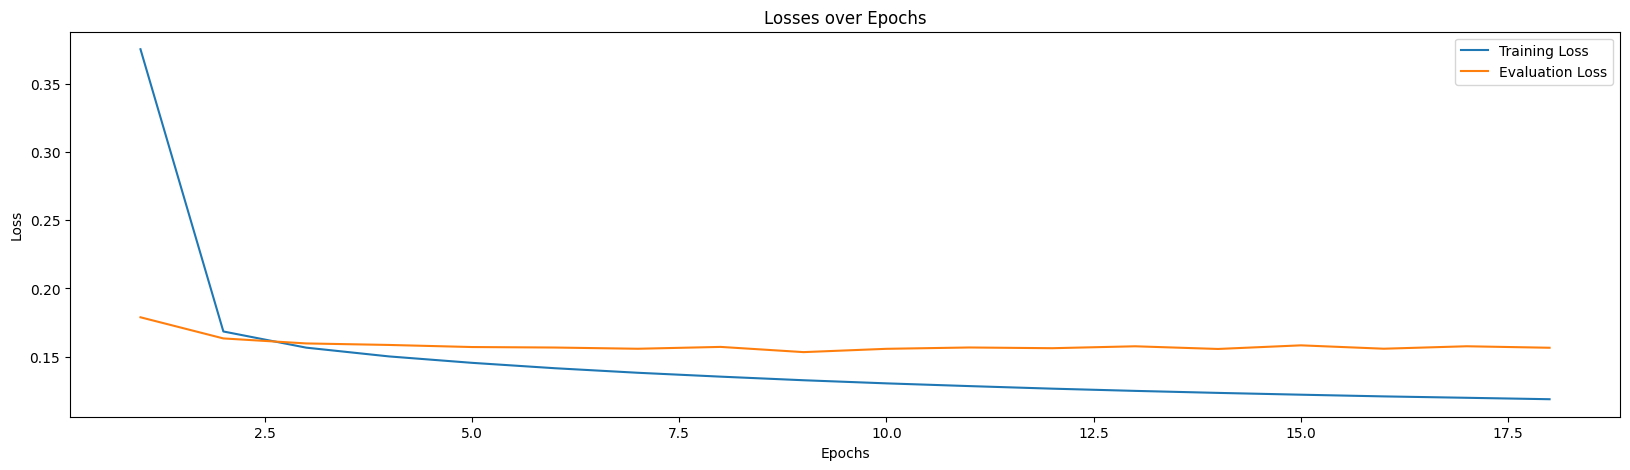

In [9]:
lossPlot(losses)

In [10]:
interactive_output_visualization(losses["labels"], duration=4, randomseed=False, output=True, output_data=losses["outputs"])
interactive_output_visualization(losses["labels_t"], duration=4, randomseed=False, output=True, output_data=losses["outputs_t"])

Remove later \\ For manual observation

In [11]:
print(losses["outputs_t"])
print()
print(losses["labels_t"])

[[-0.22666356  1.8385621  -1.0482256 ]
 [-0.07633594  1.3284552  -0.04995683]
 [ 1.411589    0.5164504   0.4582865 ]
 ...
 [-0.5824683  -1.2830094  -0.49598086]
 [ 0.6507147  -0.72466606  0.05657732]
 [ 0.25118923 -0.95086545  0.17642307]]

[[-0.32134706  1.3983847  -1.1658231 ]
 [-0.04015025  1.8561776   0.30603063]
 [ 1.3149763   0.67052895  0.3681861 ]
 ...
 [-0.19775715 -1.7340056   0.38028726]
 [ 0.7388829  -0.7430077   0.02736716]
 [ 0.64369375 -1.179745    0.17120326]]


In [12]:
print(losses["outputs"])
print()
print(losses["labels"])

[[-0.8466679   0.7442346   0.5535741 ]
 [-0.8499525   0.6910119   0.49480125]
 [-0.82903296  0.6611127   0.5005363 ]
 ...
 [ 1.55588     0.19247673 -0.07447177]
 [ 1.5500542   0.19005577 -0.08261707]
 [ 1.3911791   0.07105787 -0.29170945]]

[[-0.51455855  0.6345319   0.6635679 ]
 [-0.49432316  0.63156945  0.6758016 ]
 [-0.474348    0.6273448   0.6853503 ]
 ...
 [ 1.5170327  -0.06560533  0.12764059]
 [ 1.5168868  -0.06152498  0.12844376]
 [ 1.5165348  -0.05362112  0.12474921]]
